<a href="https://colab.research.google.com/github/FarazTheAnalyst/Data-Scientist-Portfolio/blob/main/TelcoCustomerChurnPredition/Churn_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Processing and Model Training

In [2]:
#library importing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load data (original from Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


# Data *Cleaning*

In [6]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [7]:
def clean_churn_data(df):
  # Convert TotoalCharges to numeric, to handle empty strings
  df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

  # fill missing values
  df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())


  # drop a customerID as its not a feature
  df.drop("customerID", axis=1, inplace=True)

  # convert Churn to binary
  df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
  return df




In [8]:
df_clean = clean_churn_data(df)

# Feature *Engineering*

In [9]:
def engineer_feature(df):
  # create tenure groups
  df["TenureGroup"] = pd.cut(df["tenure"], bins=[-1, 12, 24, 48, 72, np.inf],
                             labels=("0-1yr", "1-2yr", "2-4yr", "4-6yr", "6+yr"))

  # create a monthly charge group
  df["MonthlyChargeGroup"] = pd.cut(df["MonthlyCharges"], bins=[0, 35, 70, 90, np.inf],
                                    labels=["low", "medium", "high", "very high"], include_lowest=True)   #or start with -0.1

  # create total charge to monthlycharge ratio
  df["chargeRatio"] = df["TotalCharges"] / df["MonthlyCharges"]
  df["chargeRatio"] = df["chargeRatio"].replace([np.inf, -np.inf], 0)

  return df

clean_df = engineer_feature(df_clean)
clean_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup,MonthlyChargeGroup,chargeRatio
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-1yr,low,1.000000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,One year,No,Mailed check,56.95,1889.50,0,2-4yr,medium,33.178227
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-1yr,medium,2.008357
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2-4yr,medium,43.516548
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-1yr,high,2.144979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,One year,Yes,Mailed check,84.80,1990.50,0,1-2yr,high,23.472877
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,4-6yr,very high,71.345930
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0-1yr,low,11.704392
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,Month-to-month,Yes,Mailed check,74.40,306.60,1,0-1yr,high,4.120968


Seperate Features and *Target*

In [10]:
# Seperate Features and Target

X = clean_df.drop("Churn", axis=1)
y = clean_df["Churn"]

In [11]:
feature_cols = X.columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

*Preprocessing*

In [12]:
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [13]:
# scale numerical columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [14]:
# check imbalance
unique, count = np.unique(y, return_counts=True)
churn_train_dict_value_count = {k:v for(k,v) in zip(unique, count)}
churn_train_dict_value_count

{np.int64(0): np.int64(5174), np.int64(1): np.int64(1869)}

In [15]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

Split Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=42, test_size=0.2)

Model Comparison Function

In [17]:
def compare_models():
  models = {
      "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
      "Random Forest": RandomForestClassifier(random_state=42),
      "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss")
  }

  results = []

  for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision_0": report["0"]["precision"],
        "Recall_0": report["0"]["recall"],
        "F1_0": report["0"]["f1-score"],
        "Precision_1": report["1"]["precision"],
        "Recall_1": report["1"]["recall"],
        "F1_1": report["1"]["f1-score"],
        "AUC": auc

    })

    # Save confusion matrix for the best model
    if name == "XGBoost":
      plt.figure(figsize=(8, 6))
      cm = confusion_matrix(y_test, y_pred)
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
      plt.title("Confusion Matrix - XGBoost")
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.tight_layout()
      plt.savefig("confusion_matrix_xgboost.png")

      # Plot feature importance
      if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(10, 8))
        feature_importance = pd.DataFrame({
            "feature": X.columns,
            "importances": model.feature_importances_
        }).sort_values("importances", ascending=False).head(10)

        sns.barplot(x="importances", y="feature", data=feature_importance)
        plt.title("Top 10 Important Features - XGBoost")
        plt.tight_layout()
        plt.savefig("feature_importances_xgboost.png")

  return pd.DataFrame(results)


Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Model Comparision Results:
              Model  Accuracy  Precision_0  Recall_0     F1_0  Precision_1  Recall_1     F1_1      AUC
Logistic Regression  0.804831     0.843159  0.742409 0.789583     0.775406  0.865586 0.818018 0.803998
      Random Forest  0.850725     0.861789  0.830558 0.845885     0.840700  0.870353 0.855269 0.850455
            XGBoost  0.840580     0.850761  0.820764 0.835494     0.831336  0.859867 0.845361 0.840315


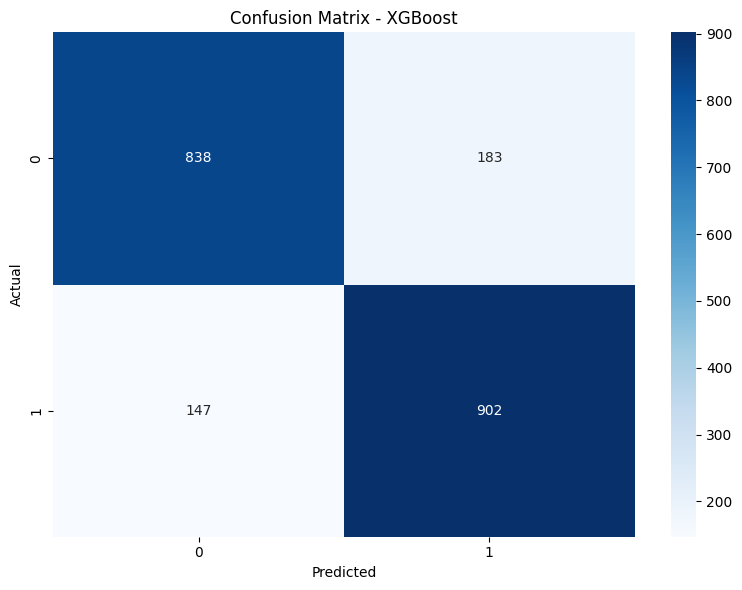

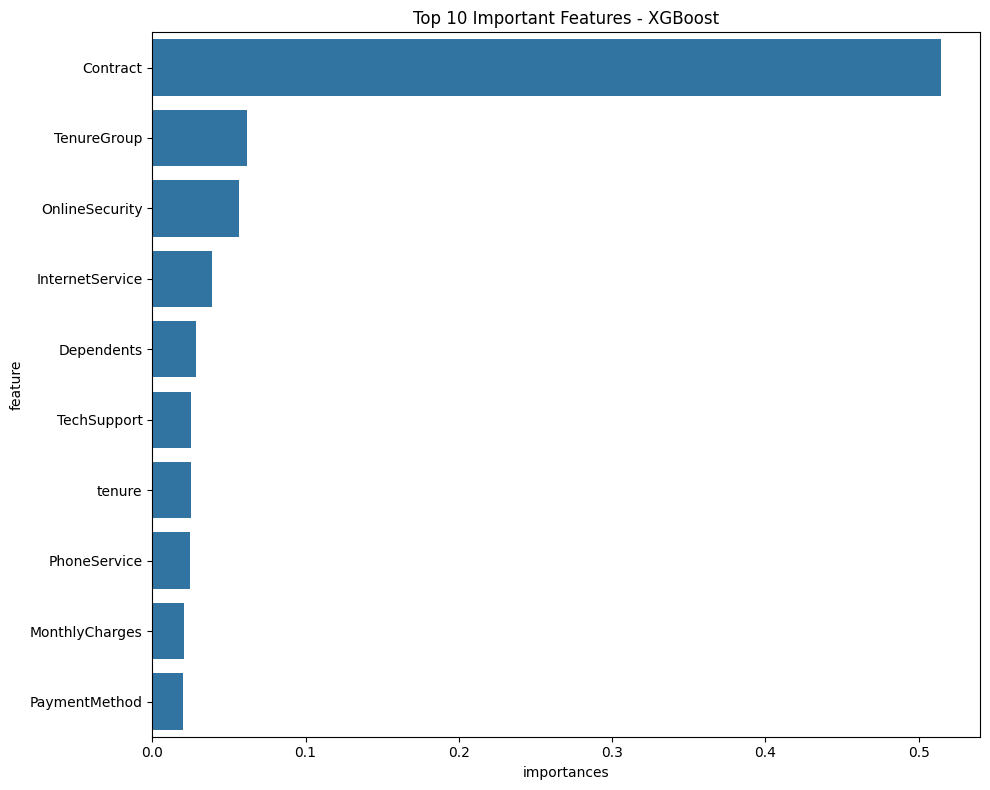

In [18]:
# Compare models
results_df = compare_models()
print(f"Model Comparision Results:")
print(results_df.to_string(index=False))

In [19]:
# Hyper parameter tuning for best model
print("\nPerforming hyperparameter tuning for XGBoost...")
param_grid = {
    "max_depth": [3, 5, 7],
    "Learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "subsample": [0.8, 0.9, 1.0]
}

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                          cv=3, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)


print(f"Best Prammeter: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Performing hyperparameter tuning for XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:59:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "Learning_rate" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Prammeter: {'Learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Best Score: 0.9066720641864484


In [20]:
# Train and save the best Model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Save model and preprocessing objects
joblib.dump(best_model, "churn_predictor_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_cols, "feature_cols.pkl")
joblib.dump(categorical_cols, "categorical_cols.pk")
joblib.dump(numerical_cols, "numerical_cols.pkl")

print("\nModel training complete. best model saved as 'churn_predictor.pkl")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:59:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "Learning_rate" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model training complete. best model saved as 'churn_predictor.pkl
